In [67]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('bmh')

In [68]:
df_restoran = pd.read_excel(r'd:\Работа ВВЮ\DataScience\Final project\Restoran.xlsx')

In [69]:
df_dostavka = pd.read_excel(r'd:\Работа ВВЮ\DataScience\Final project\Dostavka.xlsx')

In [70]:
df_restoran.head()

,Торговое предприятие,Категория,Подкатегория,Блюдо,Время открытия,Номер чека,Количество блюд,"Сумма со скидкой, грн.","Себестоимость, грн."
0,Ресторан,Алкоголь,Алкоголь - Вино,"2204109300 Visiega Cava Brut 0,75л",2021-01-02 21:43:40,35479,1.0,300.0,196.10
1,Ресторан,Алкоголь,Алкоголь - Вино,"2204109300 Visiega Cava Brut 0,75л",2021-01-03 19:17:07,35660,0.5,150.0,98.05
2,Ресторан,Алкоголь,Алкоголь - Вино,"2204109300 Visiega Cava Brut 0,75л",2021-01-03 21:55:55,35662,0.5,150.0,98.05
3,Ресторан,Алкоголь,Алкоголь - Вино,"2204109300 Visiega Cava Brut 0,75л",2021-01-05 18:24:26,35908,1.0,300.0,196.10
4,Ресторан,Алкоголь,Алкоголь - Вино,"2204109300 Visiega Cava Brut 0,75л",2021-01-25 13:00:03,36622,3.0,900.0,514.01


In [143]:
df_r_sort=df_restoran.sort_values('Время открытия', ascending=[True])
df_r_daily=df_r_sort.groupby(pd.Grouper(key='Время открытия', freq='1D')).sum().copy()
df_r_daily.reset_index(inplace=True)
df_r_daily['Время открытия'] = pd.to_datetime(df_r_daily['Время открытия']) 
data_r=df_r_daily[['Время открытия', 'Сумма со скидкой, грн.']].copy()
data_r=data_r.rename(columns={'Время открытия': 'Time', 'Сумма со скидкой, грн.': 'Sales'})
data_r=data_r.set_index('Time').asfreq('d')
data_r.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25',
               '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29',
               '2021-08-30', '2021-08-31'],
              dtype='datetime64[ns]', name='Time', length=243, freq='D')

In [144]:
df_d_sort=df_dostavka.sort_values('Время открытия', ascending=[True])
df_d_daily=df_d_sort.groupby(pd.Grouper(key='Время открытия', freq='1D')).sum().copy()
df_d_daily.reset_index(inplace=True)
df_d_daily['Время открытия'] = pd.to_datetime(df_d_daily['Время открытия']) 
data_d=df_d_daily[['Время открытия', 'Сумма со скидкой, грн.']].copy()
data_d=data_d.rename(columns={'Время открытия': 'Time', 'Сумма со скидкой, грн.': 'Sales'})
data_d=data_d.set_index('Time').asfreq('d')
data_r.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25',
               '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29',
               '2021-08-30', '2021-08-31'],
              dtype='datetime64[ns]', name='Time', length=243, freq='D')

In [160]:
data=pd.concat([data_r, data_d], ignore_index=False)
data=data.reset_index()
data=data.sort_values('Time', ascending=[True])
data=data.groupby(['Time'])['Sales'].sum()
data_0 = data[data.index >= '2021-01-01']
data_0=pd.DataFrame(data_0)
data_0=data_0.reset_index()
data_0=data_0.set_index('Time').asfreq('d')
data_0.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25',
               '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29',
               '2021-08-30', '2021-08-31'],
              dtype='datetime64[ns]', name='Time', length=243, freq='D')

[Text(0.5, 0, 'Дата')]

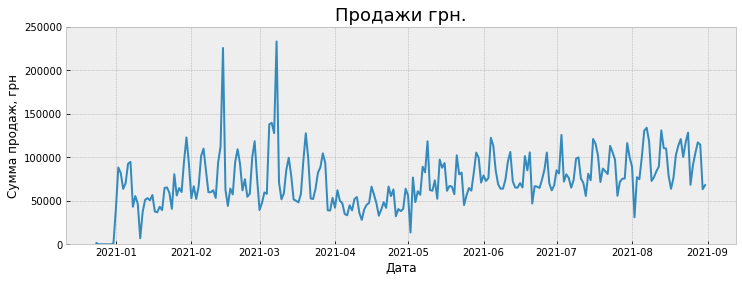

In [74]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(data)

ax.set_title('Продажи грн.', fontdict={'size':18})
ax.set(ylabel='Сумма продаж, грн', ylim=(0, 250000))
ax.set(xlabel='Дата')


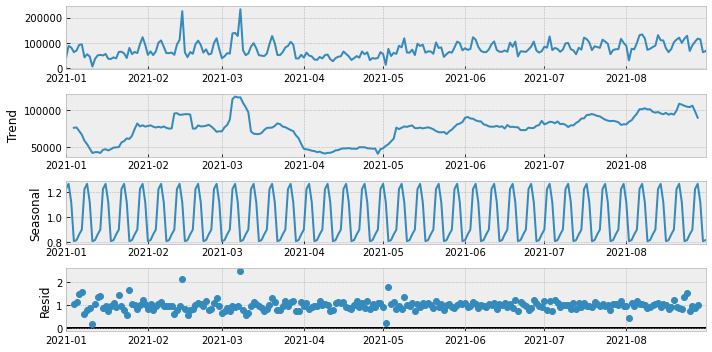

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (10,5)
result = seasonal_decompose(data_0, model='multiplicative')
result.plot()
plt.show()

In [79]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [80]:
split_date = '2021-08-01'
train, test = split_data(data_0, split_date)

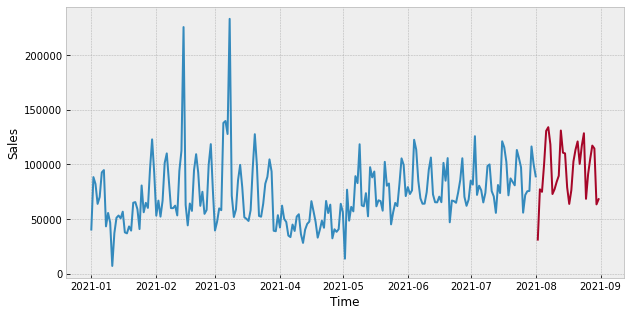

In [81]:
plt.figure(figsize=(10,5))
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [82]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','dayofyear','dayofmonth','weekofyear']]
    return X

In [83]:
X_train, y_train = create_features(train), train['Sales']
X_test, y_test   = create_features(test), test['Sales']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

<ipython-input-82-c0b10f32e311>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((213, 6), (213,), (30, 6), (30,))

In [84]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [85]:
reg = xgb.XGBRegressor(n_estimators=20)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

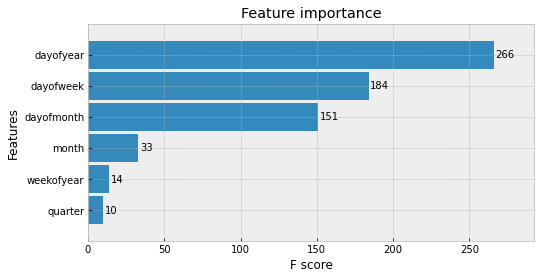

In [86]:
fig, ax = plt.subplots(figsize = (8,4))
xgb.plot_importance(reg, height=0.9, ax=ax)

In [87]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.plot(data.index,data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

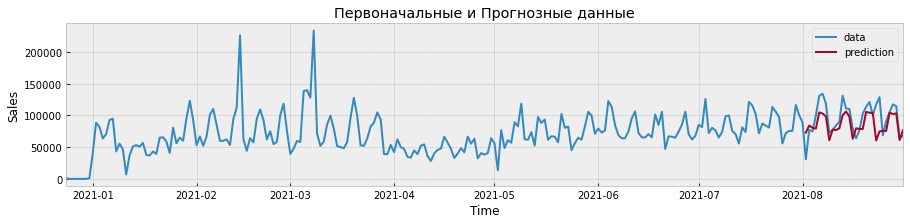

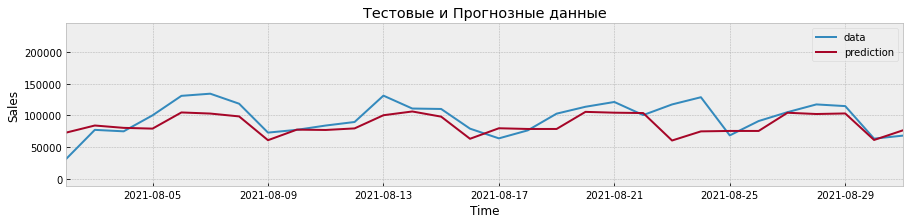

In [88]:
X_test_pred = reg.predict(X_test)
    
plot_performance(data, data.index[0].date(), data.index[-1].date(),
                 'Первоначальные и Прогнозные данные')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Тестовые и Прогнозные данные')

plt.legend()

plt.show()

In [89]:
mean_squared_error(y_true=y_test, y_pred=X_test_pred)

466580873.9042292

In [90]:
mean_absolute_error(y_true=y_test, y_pred=X_test_pred)

16206.919479166669

In [91]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [92]:
print('MAPE =', mean_absolute_percentage_error(y_test,X_test_pred).round(4))

MAPE = 18.6328


In [93]:
from sklearn.metrics import r2_score

In [94]:
r2_score(y_test, X_test_pred)

0.24750190535714378

In [95]:
print('MAE:', mean_absolute_error(y_true=y_test, y_pred=X_test_pred).round(4))
print('MSE:', mean_squared_error(y_true=y_test, y_pred=X_test_pred).round(4))
print('MAPE:', mean_absolute_percentage_error(y_test,X_test_pred).round(4))
print("r2:", (r2_score(y_test, X_test_pred)*100).round(4))

MAE: 16206.9195
MSE: 466580873.9042
MAPE: 18.6328
r2: 24.7502


### ARIMA

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

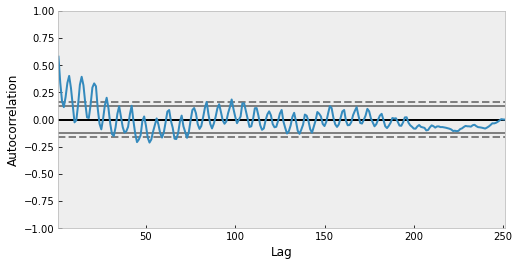

In [96]:
fig, ax = plt.subplots(figsize = (8,4))
pd.plotting.autocorrelation_plot(data)

In [97]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data_0, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  242
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2777.798
Method:                       css-mle   S.D. of innovations          23288.712
Date:                Tue, 26 Oct 2021   AIC                           5579.597
Time:                        19:59:52   BIC                           5621.464
Sample:                    01-02-2021   HQIC                          5596.462
                         - 08-31-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             73.6478    415.057      0.177      0.859    -739.850     887.145
ar.L1.D.Sales     -0.5798      0.065     -8.961      0.000      -0.707      -0.453
ar.L2.D.Sales     -0.4957      0.075

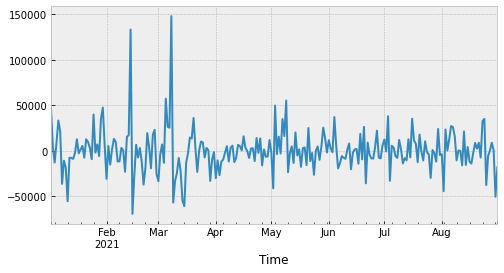

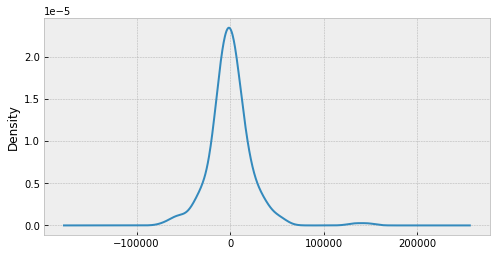

count       242.000000
mean        250.924654
std       23441.537906
min      -69123.539466
25%      -10583.466209
50%        -138.346717
75%        9246.087487
max      147936.431625
dtype: float64


In [98]:
residuals = model_fit.resid
residuals.plot(figsize=(8, 4))
plt.show()
residuals.plot(figsize=(8, 4), kind='kde')
plt.show()
print(residuals.describe())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=90470.769602, expected=81439.100000
predicted=89827.523464, expected=125767.040000
predicted=114116.323840, expected=72015.000000
predicted=79883.524162, expected=80411.590000
predicted=77648.424790, expected=76299.000000
predicted=73040.189825, expected=65086.960000
predicted=78300.246631, expected=73948.510000
predicted=87243.698810, expected=98463.470000
predicted=98210.362151, expected=99917.980000
predicted=91300.125277, expected=75524.380000
predicted=76423.884406, expected=70565.680000
predicted=63248.254207, expected=55556.340000
predicted=58237.487050, expected=81098.950000
predicted=81164.166668, expected=73689.660000
predicted=81784.729778, expected=121109.740000
predicted=107087.809255, expected=115548.250000
predicted=103470.160214, expected=102160.780000
predicted=94023.339222, expected=71610.670000
predicted=75291.799146, expected=87107.150000
predicted=91192.323711, expected=83898.500000
predicted=100368.424957, expected=80779.960000
predicted=106061.167047, e

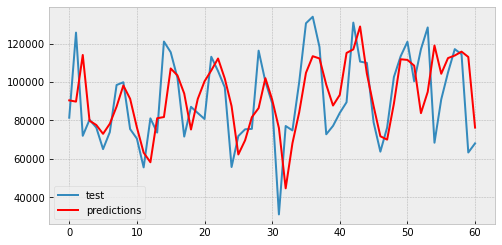

In [53]:
X = data_0.Sales
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
test1 =[x for x in test]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test1, predictions)
print('Test MSE: %.3f' % error)
# plot
fig, ax = plt.subplots(figsize = (8,4))
plt.plot(test1, label = 'test')
plt.plot(predictions, color='red', label = 'predictions')
plt.legend()
plt.show()

In [99]:
error_MSE = mean_squared_error(test, predictions)
error_MAE = mean_absolute_error(test, predictions)
error_MAPE = mean_absolute_percentage_error(test, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [30, 61]

In [52]:
print('MAE:', error_MAE.round(4))
print('MSE:', error_MSE.round(4))
print('MAPE:', error_MAPE.round(4))


MAE: 14871.0354
MSE: 391090066.2898
MAPE: 28.5033


### SARIMA

In [189]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = data_0
my_order = (2, 1, 1)
my_seasonal_order = (2, 1, 1, 7)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, enforced_stationarity = True, enforce_inveribility = True)
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  243
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -2713.146
Date:                           Tue, 26 Oct 2021   AIC                           5440.291
Time:                                   21:20:30   BIC                           5464.508
Sample:                               01-01-2021   HQIC                          5450.054
                                    - 08-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2809      0.131      2.144      0.032       0.024       0.538
ar.L2          0.0917      0.109      0.841

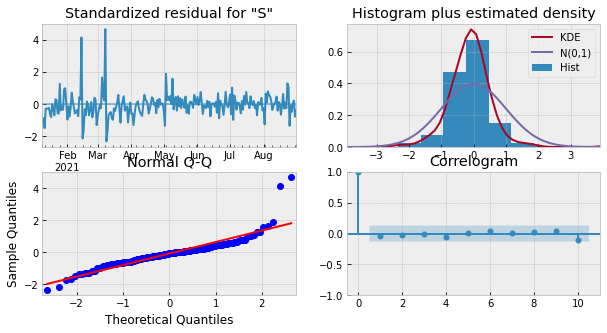

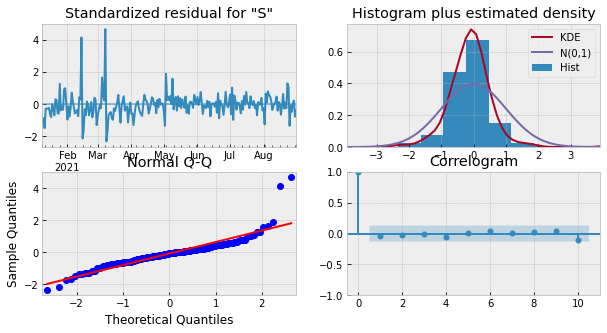

In [190]:
model_fit.plot_diagnostics(figsize=(10,5))

In [191]:
forecast_values = model_fit.get_forecast(30)
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#print(forecast_ci)

Sales,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-01,76247.839907,31206.958635,15083.324915,137412.354899
2021-09-02,86161.134369,33581.812878,20341.990593,151980.278146
2021-09-03,113938.409884,35034.717598,45271.625183,182605.194584
2021-09-04,116665.786049,35845.393429,46410.105916,186921.466182
2021-09-05,106528.970415,36463.046477,35062.712554,177995.228276
2021-09-06,81449.687849,36988.142614,8954.260471,153945.115228
2021-09-07,85067.845142,37470.917700,11626.195981,158509.494302
2021-09-08,83006.630024,38476.536424,7594.004383,158419.255665
2021-09-09,90144.792709,39103.672506,13503.002934,166786.582484
2021-09-10,116562.481909,39678.515146,38794.021263,194330.942554


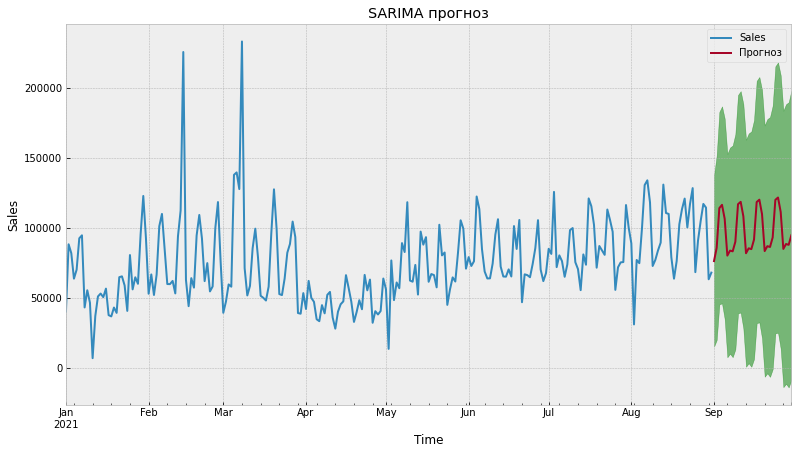

In [188]:
ax = data_0.plot(figsize=(13, 7))

forecast_values.predicted_mean.plot(ax=ax, label = 'Прогноз')

ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color = 'g', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.set_title('SARIMA прогноз')

plt.legend()